In [3]:
"""
VitalDB 데이터 분포 분석
====================================
전체 환자 데이터 중 몇 명이 필터링 조건을 만족하는지 확인
"""

import vitaldb
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# 스타일 설정
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("=" * 80)
print("VitalDB 데이터 분포 분석 시작")
print("=" * 80)

VitalDB 데이터 분포 분석 시작


In [4]:
# 1단계: 전체 VitalDB 케이스 수 확인
print("\n[1단계] 전체 케이스 수 확인")
print("-" * 80)

# Propofol이 사용된 케이스 확인
ppf_cases = list(vitaldb.caseids_ppf)
total_cases = len(ppf_cases)

print(f"✓ Propofol이 사용된 전체 케이스 수: {total_cases:,}개")
print(f"✓ 분석할 샘플 수: {min(1000, total_cases):,}개 (처음 1000개만 확인)")

check_cases = ppf_cases[:]


[1단계] 전체 케이스 수 확인
--------------------------------------------------------------------------------
✓ Propofol이 사용된 전체 케이스 수: 3,494개
✓ 분석할 샘플 수: 1,000개 (처음 1000개만 확인)


In [5]:
# 2단계: 각 케이스의 데이터 유무와 품질 확인
print("\n[2단계] 각 케이스 데이터 확인 (BIS, Propofol, Remifentanil)")
print("-" * 80)

# 필터링 기준
MIN_DURATION = 1800  # 30분 (초 단위)
BIS_MIN, BIS_MAX = 30, 70
MIN_BIS_COVERAGE = 0.3  # BIS 데이터가 최소 30% 이상 있어야 함

results = {
    'caseid': [],
    'has_bis': [],
    'has_propofol': [],
    'has_remifentanil': [],
    'duration_sec': [],
    'bis_coverage': [],  # BIS 데이터가 얼마나 있는지
    'bis_in_range_ratio': [],  # BIS가 목표 범위(30-70)에 있는 비율
    'mean_bis': [],
    'mean_propofol_rate': [],
    'mean_remi_rate': [],
    'passes_filter': []
}

print("케이스 체크 중... (시간이 좀 걸릴 수 있습니다)")
for caseid in tqdm(check_cases):
    try:
        # BIS와 약물 데이터 로드 (10초 간격)
        track_names = [
            'BIS/BIS',
            'Orchestra/PPF20_RATE',
            'Orchestra/RFTN20_RATE',
            'Orchestra/RFTN50_RATE'
        ]
        
        data = vitaldb.load_case(caseid, track_names, interval=10.0)
        
        if data is None or len(data) == 0:
            results['caseid'].append(caseid)
            results['has_bis'].append(False)
            results['has_propofol'].append(False)
            results['has_remifentanil'].append(False)
            results['duration_sec'].append(0)
            results['bis_coverage'].append(0.0)
            results['bis_in_range_ratio'].append(0.0)
            results['mean_bis'].append(np.nan)
            results['mean_propofol_rate'].append(np.nan)
            results['mean_remi_rate'].append(np.nan)
            results['passes_filter'].append(False)
            continue
        
        # 데이터 추출
        bis = data[:, 0] if data.shape[1] > 0 else np.array([])
        ppf_rate = data[:, 1] if data.shape[1] > 1 else np.array([])
        rftn20_rate = data[:, 2] if data.shape[1] > 2 else np.array([])
        rftn50_rate = data[:, 3] if data.shape[1] > 3 else np.array([])
        
        # Remifentanil: RFTN20과 RFTN50 중 하나라도 있으면 OK
        remi_rate = np.where(
            pd.notna(rftn20_rate) & (rftn20_rate > 0),
            rftn20_rate,
            rftn50_rate if pd.notna(rftn50_rate).any() else rftn20_rate
        )
        
        # 기본 정보
        duration = len(data) * 10  # 10초 간격
        has_bis = pd.notna(bis).any()
        has_propofol = pd.notna(ppf_rate).any() and (ppf_rate > 0).any()
        has_remi = pd.notna(remi_rate).any() and (remi_rate > 0).any()
        
        # BIS 커버리지 (데이터가 있는 비율)
        bis_coverage = pd.notna(bis).sum() / len(bis) if len(bis) > 0 else 0.0
        
        # BIS가 목표 범위에 있는 비율
        valid_bis = bis[pd.notna(bis)]
        bis_in_range_ratio = ((valid_bis >= BIS_MIN) & (valid_bis <= BIS_MAX)).sum() / len(valid_bis) if len(valid_bis) > 0 else 0.0
        
        # 평균값
        mean_bis = np.nanmean(bis) if has_bis else np.nan
        mean_ppf = np.nanmean(ppf_rate[ppf_rate > 0]) if has_propofol else np.nan
        mean_remi = np.nanmean(remi_rate[remi_rate > 0]) if has_remi else np.nan
        
        # 필터 통과 여부
        passes = (
            duration >= MIN_DURATION and
            has_bis and
            has_propofol and
            bis_coverage >= MIN_BIS_COVERAGE and
            bis_in_range_ratio > 0.1  # BIS가 목표 범위에 최소 10% 이상
        )
        
        # 결과 저장
        results['caseid'].append(caseid)
        results['has_bis'].append(has_bis)
        results['has_propofol'].append(has_propofol)
        results['has_remifentanil'].append(has_remi)
        results['duration_sec'].append(duration)
        results['bis_coverage'].append(bis_coverage)
        results['bis_in_range_ratio'].append(bis_in_range_ratio)
        results['mean_bis'].append(mean_bis)
        results['mean_propofol_rate'].append(mean_ppf)
        results['mean_remi_rate'].append(mean_remi)
        results['passes_filter'].append(passes)
        
    except Exception as e:
        # 에러 발생 시 기본값
        results['caseid'].append(caseid)
        results['has_bis'].append(False)
        results['has_propofol'].append(False)
        results['has_remifentanil'].append(False)
        results['duration_sec'].append(0)
        results['bis_coverage'].append(0.0)
        results['bis_in_range_ratio'].append(0.0)
        results['mean_bis'].append(np.nan)
        results['mean_propofol_rate'].append(np.nan)
        results['mean_remi_rate'].append(np.nan)
        results['passes_filter'].append(False)

# DataFrame으로 변환
df_results = pd.DataFrame(results)
print(f"\n✓ {len(df_results)}개 케이스 분석 완료!")


[2단계] 각 케이스 데이터 확인 (BIS, Propofol, Remifentanil)
--------------------------------------------------------------------------------
케이스 체크 중... (시간이 좀 걸릴 수 있습니다)


  0%|          | 0/3494 [00:00<?, ?it/s]

100%|██████████| 3494/3494 [1:31:57<00:00,  1.58s/it]


✓ 3494개 케이스 분석 완료!


In [6]:
# 3단계: 필터링 단계별 통계 출력
print("\n[3단계] 필터링 단계별 통계")
print("=" * 80)

total_checked = len(df_results)

# 1) BIS 데이터 유무
with_bis = df_results['has_bis'].sum()
print(f"\n1️⃣ BIS 데이터가 있는 케이스:")
print(f"   {with_bis:,} / {total_checked:,} ({with_bis/total_checked*100:.1f}%)")

# 2) Propofol 데이터 유무
with_propofol = df_results['has_propofol'].sum()
print(f"\n2️⃣ Propofol 데이터가 있는 케이스:")
print(f"   {with_propofol:,} / {total_checked:,} ({with_propofol/total_checked*100:.1f}%)")

# 3) Remifentanil 데이터 유무
with_remi = df_results['has_remifentanil'].sum()
print(f"\n3️⃣ Remifentanil 데이터가 있는 케이스:")
print(f"   {with_remi:,} / {total_checked:,} ({with_remi/total_checked*100:.1f}%)")

# 4) BIS + Propofol 모두 있는 케이스
with_both = (df_results['has_bis'] & df_results['has_propofol']).sum()
print(f"\n4️⃣ BIS + Propofol 모두 있는 케이스:")
print(f"   {with_both:,} / {total_checked:,} ({with_both/total_checked*100:.1f}%)")

# 5) 최소 길이 조건 (30분 이상)
long_enough = (df_results['duration_sec'] >= MIN_DURATION).sum()
print(f"\n5️⃣ 길이가 {MIN_DURATION}초({MIN_DURATION/60:.0f}분) 이상인 케이스:")
print(f"   {long_enough:,} / {total_checked:,} ({long_enough/total_checked*100:.1f}%)")

# 6) BIS 커버리지 조건 (최소 30% 데이터)
good_bis_coverage = (df_results['bis_coverage'] >= MIN_BIS_COVERAGE).sum()
print(f"\n6️⃣ BIS 커버리지가 {MIN_BIS_COVERAGE*100:.0f}% 이상인 케이스:")
print(f"   {good_bis_coverage:,} / {total_checked:,} ({good_bis_coverage/total_checked*100:.1f}%)")

# 7) BIS 범위 조건 (BIS가 30-70 범위에 최소 10% 이상)
good_bis_range = (df_results['bis_in_range_ratio'] > 0.1).sum()
print(f"\n7️⃣ BIS가 목표 범위({BIS_MIN}-{BIS_MAX})에 10% 이상 있는 케이스:")
print(f"   {good_bis_range:,} / {total_checked:,} ({good_bis_range/total_checked*100:.1f}%)")

# 최종: 모든 필터 통과
passes_all = df_results['passes_filter'].sum()
print(f"\n" + "=" * 80)
print(f"🎯 최종: 모든 필터를 통과한 케이스:")
print(f"   {passes_all:,} / {total_checked:,} ({passes_all/total_checked*100:.1f}%)")
print("=" * 80)


[3단계] 필터링 단계별 통계

1️⃣ BIS 데이터가 있는 케이스:
   3,327 / 3,494 (95.2%)

2️⃣ Propofol 데이터가 있는 케이스:
   3,492 / 3,494 (99.9%)

3️⃣ Remifentanil 데이터가 있는 케이스:
   3,491 / 3,494 (99.9%)

4️⃣ BIS + Propofol 모두 있는 케이스:
   3,325 / 3,494 (95.2%)

5️⃣ 길이가 1800초(30분) 이상인 케이스:
   3,492 / 3,494 (99.9%)

6️⃣ BIS 커버리지가 30% 이상인 케이스:
   3,316 / 3,494 (94.9%)

7️⃣ BIS가 목표 범위(30-70)에 10% 이상 있는 케이스:
   3,280 / 3,494 (93.9%)

🎯 최종: 모든 필터를 통과한 케이스:
   3,270 / 3,494 (93.6%)



[4단계] 데이터 분포 시각화
--------------------------------------------------------------------------------


/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/793281975.py:121: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825

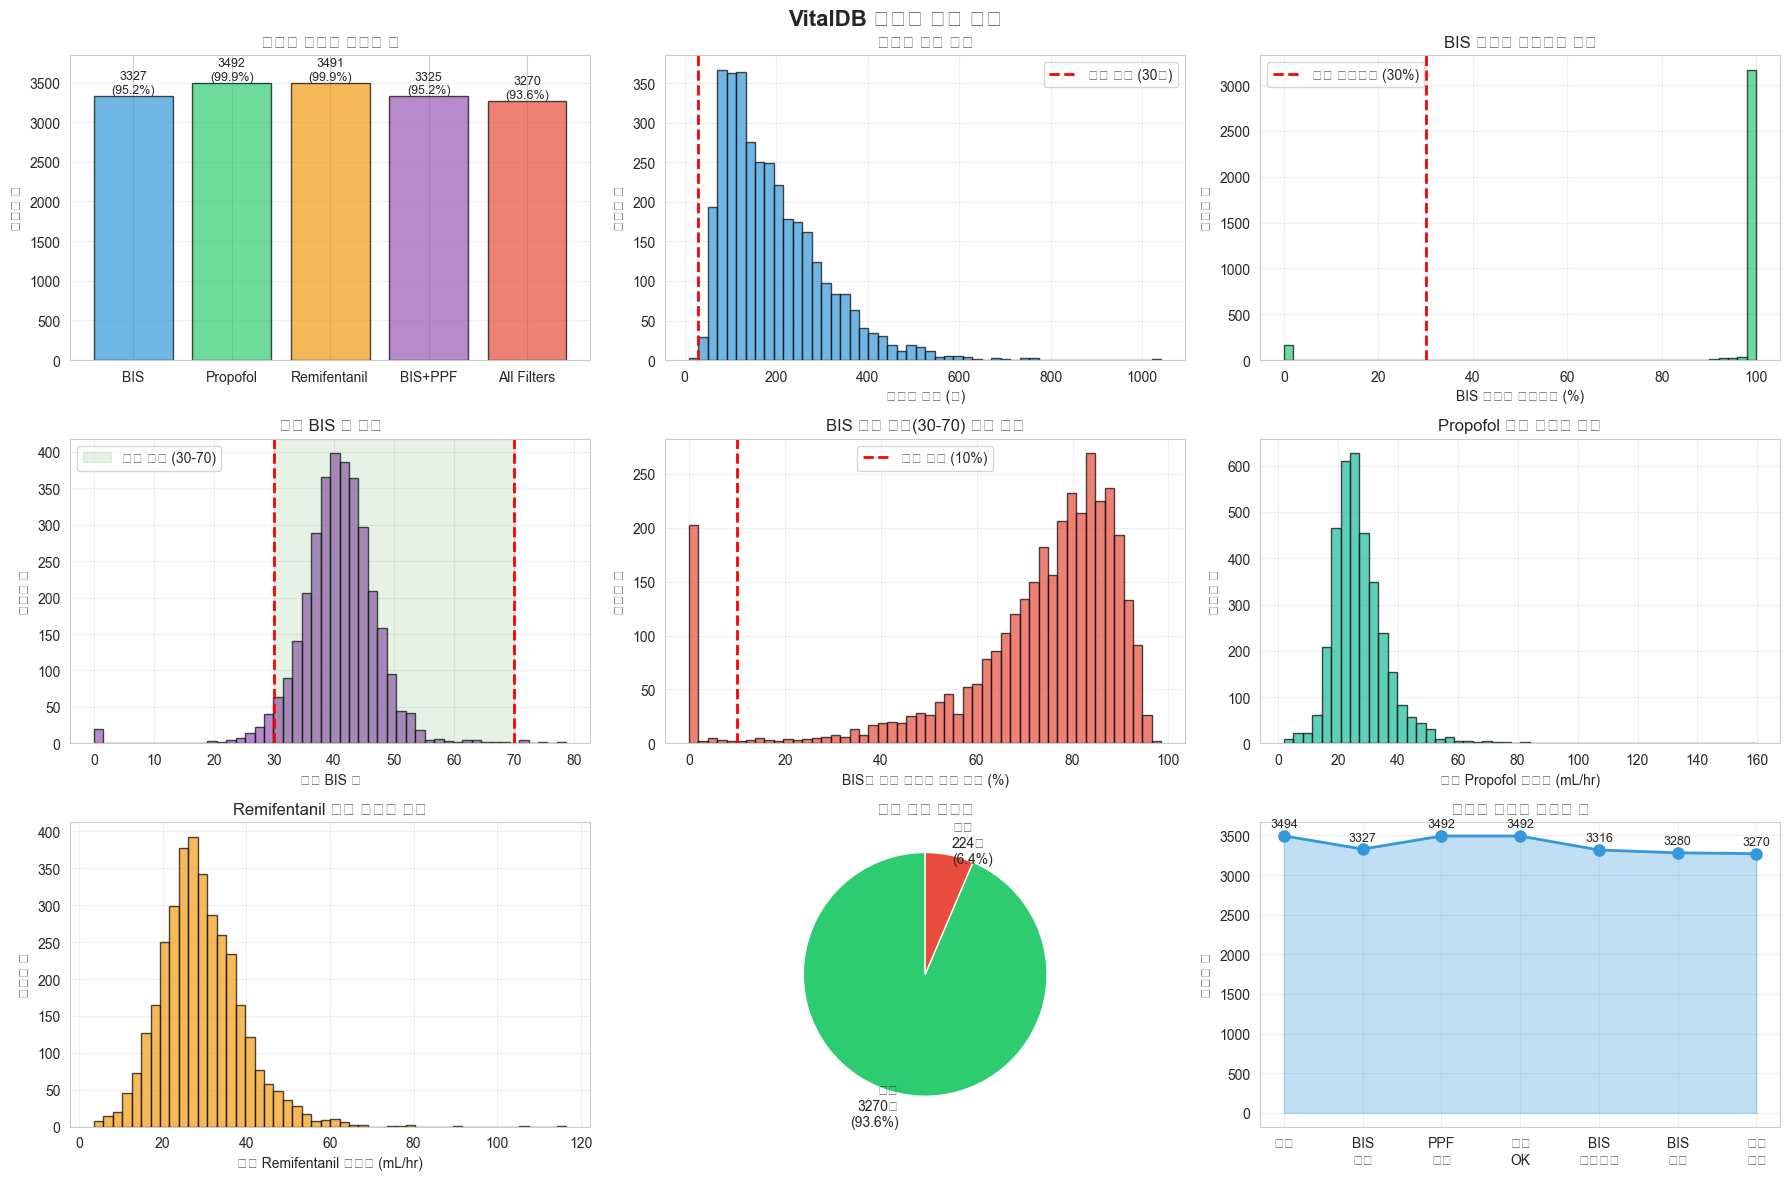

✓ 시각화 완료!


In [7]:
# 4단계: 시각화 - 데이터 분포
print("\n[4단계] 데이터 분포 시각화")
print("-" * 80)

fig, axes = plt.subplots(3, 3, figsize=(18, 12))
fig.suptitle('VitalDB 데이터 분포 분석', fontsize=16, fontweight='bold')

# 1) 데이터 유무 막대 그래프
ax = axes[0, 0]
categories = ['BIS', 'Propofol', 'Remifentanil', 'BIS+PPF', 'All Filters']
counts = [
    with_bis,
    with_propofol,
    with_remi,
    with_both,
    passes_all
]
colors = ['#3498db', '#2ecc71', '#f39c12', '#9b59b6', '#e74c3c']
bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('케이스 수')
ax.set_title('데이터 유무별 케이스 수')
ax.set_ylim(0, total_checked * 1.1)
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({count/total_checked*100:.1f}%)',
            ha='center', va='bottom', fontsize=9)
ax.grid(axis='y', alpha=0.3)

# 2) 케이스 길이 분포
ax = axes[0, 1]
valid_durations = df_results[df_results['duration_sec'] > 0]['duration_sec'] / 60  # 분 단위
ax.hist(valid_durations, bins=50, color='#3498db', alpha=0.7, edgecolor='black')
ax.axvline(MIN_DURATION/60, color='red', linestyle='--', linewidth=2, label=f'최소 길이 ({MIN_DURATION/60:.0f}분)')
ax.set_xlabel('케이스 길이 (분)')
ax.set_ylabel('케이스 수')
ax.set_title('케이스 길이 분포')
ax.legend()
ax.grid(alpha=0.3)

# 3) BIS 커버리지 분포
ax = axes[0, 2]
ax.hist(df_results['bis_coverage'] * 100, bins=50, color='#2ecc71', alpha=0.7, edgecolor='black')
ax.axvline(MIN_BIS_COVERAGE * 100, color='red', linestyle='--', linewidth=2, label=f'최소 커버리지 ({MIN_BIS_COVERAGE*100:.0f}%)')
ax.set_xlabel('BIS 데이터 커버리지 (%)')
ax.set_ylabel('케이스 수')
ax.set_title('BIS 데이터 커버리지 분포')
ax.legend()
ax.grid(alpha=0.3)

# 4) BIS 평균값 분포
ax = axes[1, 0]
valid_bis = df_results[df_results['mean_bis'].notna()]['mean_bis']
ax.hist(valid_bis, bins=50, color='#9b59b6', alpha=0.7, edgecolor='black')
ax.axvline(BIS_MIN, color='red', linestyle='--', linewidth=2)
ax.axvline(BIS_MAX, color='red', linestyle='--', linewidth=2)
ax.axvspan(BIS_MIN, BIS_MAX, alpha=0.1, color='green', label=f'목표 범위 ({BIS_MIN}-{BIS_MAX})')
ax.set_xlabel('평균 BIS 값')
ax.set_ylabel('케이스 수')
ax.set_title('평균 BIS 값 분포')
ax.legend()
ax.grid(alpha=0.3)

# 5) BIS 범위 내 비율
ax = axes[1, 1]
ax.hist(df_results['bis_in_range_ratio'] * 100, bins=50, color='#e74c3c', alpha=0.7, edgecolor='black')
ax.axvline(10, color='red', linestyle='--', linewidth=2, label='최소 비율 (10%)')
ax.set_xlabel('BIS가 목표 범위에 있는 비율 (%)')
ax.set_ylabel('케이스 수')
ax.set_title(f'BIS 목표 범위({BIS_MIN}-{BIS_MAX}) 비율 분포')
ax.legend()
ax.grid(alpha=0.3)

# 6) Propofol 평균 투여율 분포
ax = axes[1, 2]
valid_ppf = df_results[df_results['mean_propofol_rate'].notna()]['mean_propofol_rate']
ax.hist(valid_ppf, bins=50, color='#1abc9c', alpha=0.7, edgecolor='black')
ax.set_xlabel('평균 Propofol 투여율 (mL/hr)')
ax.set_ylabel('케이스 수')
ax.set_title('Propofol 평균 투여율 분포')
ax.grid(alpha=0.3)

# 7) Remifentanil 평균 투여율 분포
ax = axes[2, 0]
valid_remi = df_results[df_results['mean_remi_rate'].notna()]['mean_remi_rate']
ax.hist(valid_remi, bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
ax.set_xlabel('평균 Remifentanil 투여율 (mL/hr)')
ax.set_ylabel('케이스 수')
ax.set_title('Remifentanil 평균 투여율 분포')
ax.grid(alpha=0.3)

# 8) 필터 통과/실패 파이 차트
ax = axes[2, 1]
pass_fail = [passes_all, total_checked - passes_all]
labels = [f'통과\n{passes_all}개\n({passes_all/total_checked*100:.1f}%)',
          f'실패\n{total_checked - passes_all}개\n({(total_checked - passes_all)/total_checked*100:.1f}%)']
colors_pie = ['#2ecc71', '#e74c3c']
ax.pie(pass_fail, labels=labels, colors=colors_pie, autopct='', startangle=90)
ax.set_title('최종 필터 통과율')

# 9) 단계별 필터링 폭포 차트
ax = axes[2, 2]
filter_steps = ['전체', 'BIS\n있음', 'PPF\n있음', '길이\nOK', 'BIS\n커버리지', 'BIS\n범위', '최종\n통과']
filter_counts = [
    total_checked,
    with_bis,
    with_propofol,
    long_enough,
    good_bis_coverage,
    good_bis_range,
    passes_all
]
ax.plot(filter_steps, filter_counts, marker='o', linewidth=2, markersize=8, color='#3498db')
ax.fill_between(range(len(filter_steps)), filter_counts, alpha=0.3, color='#3498db')
ax.set_ylabel('케이스 수')
ax.set_title('필터링 단계별 케이스 수')
ax.grid(alpha=0.3)
for i, (step, count) in enumerate(zip(filter_steps, filter_counts)):
    ax.text(i, count + total_checked * 0.02, f'{count}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("✓ 시각화 완료!")

In [8]:
# 5단계: 필터를 통과한 케이스의 상세 정보
print("\n[5단계] 필터를 통과한 케이스 상세 정보")
print("=" * 80)

passed_cases = df_results[df_results['passes_filter']]

if len(passed_cases) > 0:
    print(f"\n총 {len(passed_cases)}개 케이스가 필터를 통과했습니다:\n")
    
    # 상위 20개 케이스만 표시
    display_df = passed_cases[['caseid', 'duration_sec', 'bis_coverage', 
                                'bis_in_range_ratio', 'mean_bis', 
                                'mean_propofol_rate', 'mean_remi_rate']].head(20).copy()
    
    # 포맷팅
    display_df['duration_min'] = (display_df['duration_sec'] / 60).round(1)
    display_df['bis_coverage_%'] = (display_df['bis_coverage'] * 100).round(1)
    display_df['bis_range_%'] = (display_df['bis_in_range_ratio'] * 100).round(1)
    display_df['mean_bis'] = display_df['mean_bis'].round(1)
    display_df['mean_ppf'] = display_df['mean_propofol_rate'].round(2)
    display_df['mean_remi'] = display_df['mean_remi_rate'].round(2)
    
    # 표시할 컬럼만 선택
    display_df = display_df[['caseid', 'duration_min', 'bis_coverage_%', 
                              'bis_range_%', 'mean_bis', 'mean_ppf', 'mean_remi']]
    
    display_df.columns = ['케이스ID', '길이(분)', 'BIS커버리지(%)', 
                          'BIS범위내(%)', '평균BIS', '평균PPF', '평균Remi']
    
    print(display_df.to_string(index=False))
    
    if len(passed_cases) > 20:
        print(f"\n... 외 {len(passed_cases) - 20}개 케이스")
    
    # 통계 요약
    print(f"\n" + "=" * 80)
    print("통과한 케이스 통계 요약:")
    print("-" * 80)
    print(f"평균 길이: {passed_cases['duration_sec'].mean() / 60:.1f}분 (범위: {passed_cases['duration_sec'].min() / 60:.1f} - {passed_cases['duration_sec'].max() / 60:.1f}분)")
    print(f"평균 BIS 커버리지: {passed_cases['bis_coverage'].mean() * 100:.1f}%")
    print(f"평균 BIS 범위 내 비율: {passed_cases['bis_in_range_ratio'].mean() * 100:.1f}%")
    print(f"평균 BIS 값: {passed_cases['mean_bis'].mean():.1f} (범위: {passed_cases['mean_bis'].min():.1f} - {passed_cases['mean_bis'].max():.1f})")
    print(f"평균 Propofol 투여율: {passed_cases['mean_propofol_rate'].mean():.2f} mL/hr")
    
    remi_valid = passed_cases[passed_cases['mean_remi_rate'].notna()]
    if len(remi_valid) > 0:
        print(f"평균 Remifentanil 투여율: {remi_valid['mean_remi_rate'].mean():.2f} mL/hr ({len(remi_valid)}/{len(passed_cases)} 케이스에서 사용)")
    
    print("=" * 80)
else:
    print("\n⚠️ 필터를 통과한 케이스가 없습니다!")
    print("필터 조건을 완화하는 것을 고려하세요.")


[5단계] 필터를 통과한 케이스 상세 정보

총 3270개 케이스가 필터를 통과했습니다:

 케이스ID  길이(분)  BIS커버리지(%)  BIS범위내(%)  평균BIS  평균PPF  평균Remi
     3   73.3       100.0       63.4   37.0  35.90   29.14
     5  359.0       100.0       91.3   47.1  19.06   21.72
     7  262.8        45.9       81.9   39.4  21.13   28.13
     8   98.7       100.0       63.2   35.3  23.61   19.74
     9   74.7       100.0       64.1   46.3  33.86   48.32
    13  180.2        99.8       38.5   28.6  20.91   18.71
    14   68.7       100.0       64.3   41.1  48.41   43.37
    16  214.5       100.0       86.0   39.1  19.54   29.04
    17  339.5       100.0       62.0   35.6  15.96   17.18
    19  459.7       100.0       89.7   40.1  20.35   22.47
    20  441.3       100.0       87.5   42.0  20.20   19.31
    29  356.7        99.9       91.0   42.1  15.85   22.21
    30  185.5       100.0       90.6   43.0  22.32   22.85
    31  173.7       100.0       87.2   43.4  15.86   20.79
    34  396.3       100.0       85.6   39.9  29.67   31.89
    


[6단계] 필터 실패 원인 분석

총 224개 케이스가 필터를 통과하지 못했습니다.

실패 원인별 케이스 수 (중복 가능):
--------------------------------------------------------------------------------
  BIS 범위 부족 (<10%)              :  214 케이스 ( 95.5%)
  BIS 커버리지 부족 (<30%)            :  178 케이스 ( 79.5%)
  BIS 데이터 없음                    :  167 케이스 ( 74.6%)
  Propofol 데이터 없음               :    2 케이스 (  0.9%)
  길이 부족 (<30분)                  :    2 케이스 (  0.9%)

--------------------------------------------------------------------------------
가장 흔한 실패 패턴 (상위 5개):
--------------------------------------------------------------------------------
  1. BIS없음, BIS커버리지낮음, BIS범위적음               :  166 케이스 ( 74.1%)
  2. BIS범위적음                                 :   43 케이스 ( 19.2%)
  3. BIS커버리지낮음                               :    7 케이스 (  3.1%)
  4. BIS커버리지낮음, BIS범위적음                      :    4 케이스 (  1.8%)
  5. PPF없음                                   :    2 케이스 (  0.9%)


/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 45936 (\N{HANGUL SYLLABLE DE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 53552 (\N{HANGUL SYLLABLE TEO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3530781599.py:91: UserWarning: Glyph 50630 (\N{HANGUL SYLLABLE EOBS}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_28

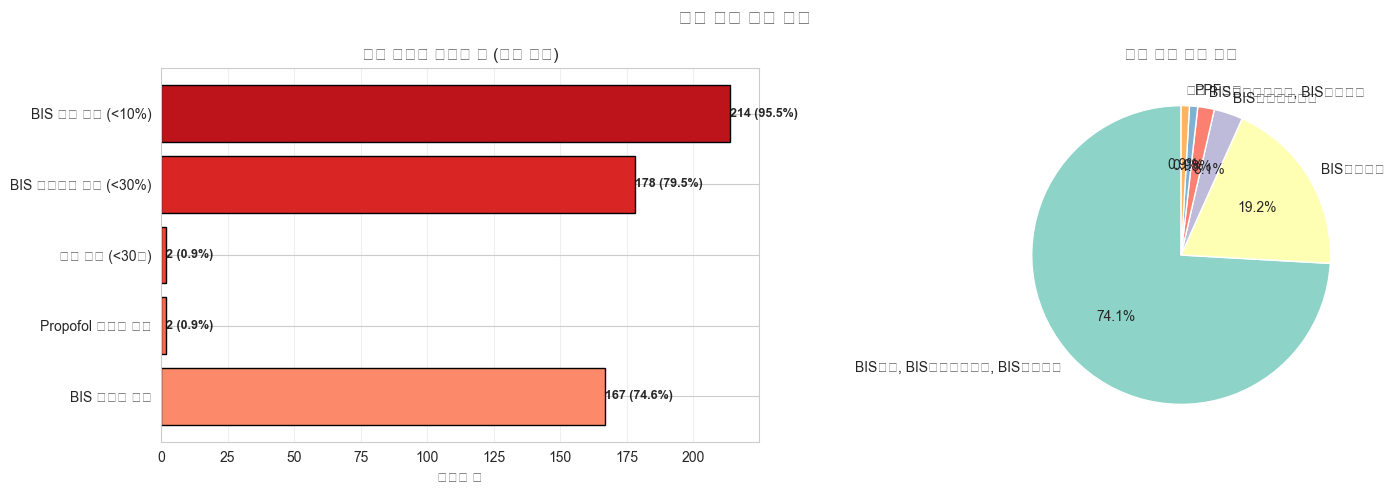

In [9]:
# 6단계: 필터를 통과하지 못한 주요 이유 분석
print("\n[6단계] 필터 실패 원인 분석")
print("=" * 80)

failed_cases = df_results[~df_results['passes_filter']]

if len(failed_cases) > 0:
    print(f"\n총 {len(failed_cases)}개 케이스가 필터를 통과하지 못했습니다.\n")
    
    # 실패 원인별 분류
    reasons = {
        'BIS 데이터 없음': (~failed_cases['has_bis']).sum(),
        'Propofol 데이터 없음': (~failed_cases['has_propofol']).sum(),
        '길이 부족 (<30분)': (failed_cases['duration_sec'] < MIN_DURATION).sum(),
        'BIS 커버리지 부족 (<30%)': (failed_cases['bis_coverage'] < MIN_BIS_COVERAGE).sum(),
        'BIS 범위 부족 (<10%)': (failed_cases['bis_in_range_ratio'] <= 0.1).sum(),
    }
    
    print("실패 원인별 케이스 수 (중복 가능):")
    print("-" * 80)
    for reason, count in sorted(reasons.items(), key=lambda x: x[1], reverse=True):
        pct = count / len(failed_cases) * 100
        print(f"  {reason:30s}: {count:4d} 케이스 ({pct:5.1f}%)")
    
    # 가장 흔한 조합
    print("\n" + "-" * 80)
    print("가장 흔한 실패 패턴 (상위 5개):")
    print("-" * 80)
    
    failed_cases_copy = failed_cases.copy()
    failed_cases_copy['fail_reasons'] = ''
    
    for idx in failed_cases_copy.index:
        reasons_list = []
        if not failed_cases_copy.loc[idx, 'has_bis']:
            reasons_list.append('BIS없음')
        if not failed_cases_copy.loc[idx, 'has_propofol']:
            reasons_list.append('PPF없음')
        if failed_cases_copy.loc[idx, 'duration_sec'] < MIN_DURATION:
            reasons_list.append('짧음')
        if failed_cases_copy.loc[idx, 'bis_coverage'] < MIN_BIS_COVERAGE:
            reasons_list.append('BIS커버리지낮음')
        if failed_cases_copy.loc[idx, 'bis_in_range_ratio'] <= 0.1:
            reasons_list.append('BIS범위적음')
        
        failed_cases_copy.loc[idx, 'fail_reasons'] = ', '.join(reasons_list) if reasons_list else '기타'
    
    top_patterns = failed_cases_copy['fail_reasons'].value_counts().head(5)
    for i, (pattern, count) in enumerate(top_patterns.items(), 1):
        pct = count / len(failed_cases) * 100
        print(f"  {i}. {pattern:40s}: {count:4d} 케이스 ({pct:5.1f}%)")
    
    print("=" * 80)
    
    # 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    fig.suptitle('필터 실패 원인 분석', fontsize=14, fontweight='bold')
    
    # 원인별 막대 그래프
    ax = axes[0]
    reason_names = list(reasons.keys())
    reason_counts = list(reasons.values())
    colors = plt.cm.Reds(np.linspace(0.4, 0.8, len(reason_names)))
    bars = ax.barh(reason_names, reason_counts, color=colors, edgecolor='black')
    ax.set_xlabel('케이스 수')
    ax.set_title('실패 원인별 케이스 수 (중복 가능)')
    ax.grid(axis='x', alpha=0.3)
    for bar, count in zip(bars, reason_counts):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f'{count} ({count/len(failed_cases)*100:.1f}%)',
                ha='left', va='center', fontsize=9, fontweight='bold')
    
    # 상위 패턴 파이 차트
    ax = axes[1]
    top5_counts = top_patterns.values[:5]
    top5_labels = [label[:30] + '...' if len(label) > 30 else label for label in top_patterns.index[:5]]
    others_count = len(failed_cases) - top5_counts.sum()
    
    if others_count > 0:
        plot_counts = list(top5_counts) + [others_count]
        plot_labels = top5_labels + ['기타']
    else:
        plot_counts = list(top5_counts)
        plot_labels = top5_labels
    
    colors_pie = plt.cm.Set3(range(len(plot_counts)))
    ax.pie(plot_counts, labels=plot_labels, autopct='%1.1f%%', startangle=90, colors=colors_pie)
    ax.set_title('상위 실패 패턴 분포')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("\n✓ 모든 케이스가 필터를 통과했습니다!")


[7단계] 필터 조건 완화 효과 시뮬레이션

시나리오별 통과 케이스 수:
--------------------------------------------------------------------------------
시나리오                                최소길이(분)      BIS커버리지      BIS범위        통과수         증가
--------------------------------------------------------------------------------
현재 조건                                   30분         30%        10%       3270           
길이 20분으로 완화                             20분         30%        10%       3270         +0
길이 15분으로 완화                             15분         30%        10%       3270         +0
BIS 커버리지 20%로 완화                        30분         20%        10%       3274         +4
BIS 범위 5%로 완화                           30분         30%         5%       3278         +8
길이+커버리지 완화                              20분         20%        10%       3274         +4
모든 조건 완화                                15분         20%         5%       3282        +12


/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3040903985.py:80: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykerne

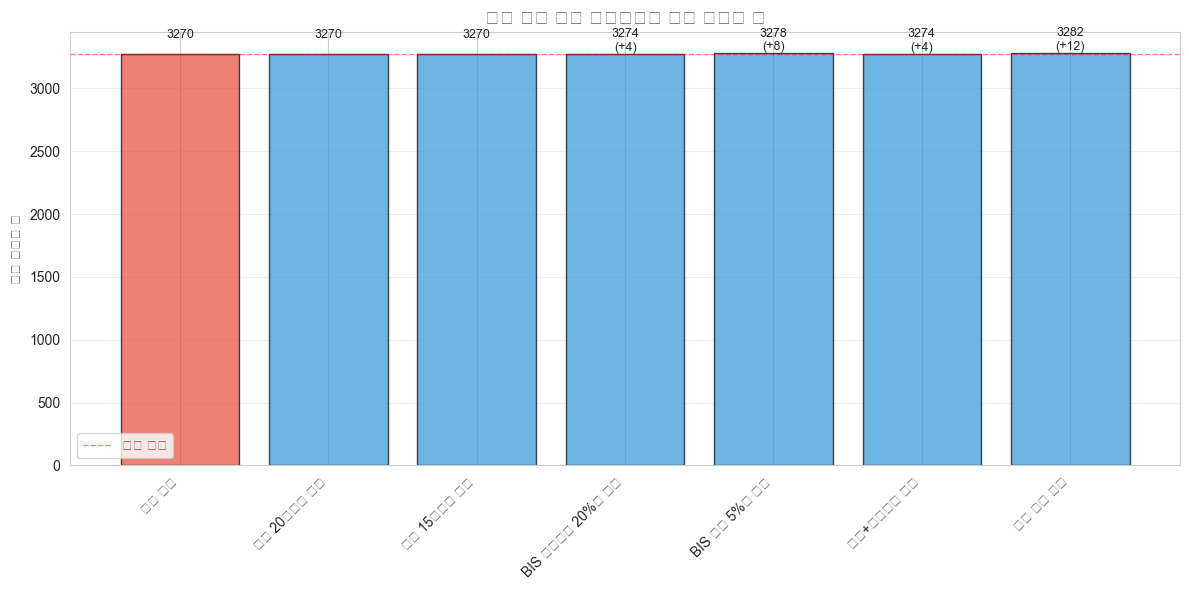


✓ 시뮬레이션 완료!


In [10]:
# 7단계: 필터 조건 완화 시뮬레이션
print("\n[7단계] 필터 조건 완화 효과 시뮬레이션")
print("=" * 80)

# 다양한 조건으로 시뮬레이션
simulations = []

# 현재 조건
current_passes = df_results['passes_filter'].sum()
simulations.append({
    'name': '현재 조건',
    'min_duration': MIN_DURATION,
    'min_bis_coverage': MIN_BIS_COVERAGE,
    'min_bis_range': 0.1,
    'passes': current_passes
})

# 조건 완화 시나리오
scenarios = [
    {'name': '길이 20분으로 완화', 'min_duration': 1200, 'min_bis_coverage': 0.3, 'min_bis_range': 0.1},
    {'name': '길이 15분으로 완화', 'min_duration': 900, 'min_bis_coverage': 0.3, 'min_bis_range': 0.1},
    {'name': 'BIS 커버리지 20%로 완화', 'min_duration': 1800, 'min_bis_coverage': 0.2, 'min_bis_range': 0.1},
    {'name': 'BIS 범위 5%로 완화', 'min_duration': 1800, 'min_bis_coverage': 0.3, 'min_bis_range': 0.05},
    {'name': '길이+커버리지 완화', 'min_duration': 1200, 'min_bis_coverage': 0.2, 'min_bis_range': 0.1},
    {'name': '모든 조건 완화', 'min_duration': 900, 'min_bis_coverage': 0.2, 'min_bis_range': 0.05},
]

for scenario in scenarios:
    passes = (
        (df_results['duration_sec'] >= scenario['min_duration']) &
        df_results['has_bis'] &
        df_results['has_propofol'] &
        (df_results['bis_coverage'] >= scenario['min_bis_coverage']) &
        (df_results['bis_in_range_ratio'] > scenario['min_bis_range'])
    ).sum()
    
    simulations.append({
        'name': scenario['name'],
        'min_duration': scenario['min_duration'],
        'min_bis_coverage': scenario['min_bis_coverage'],
        'min_bis_range': scenario['min_bis_range'],
        'passes': passes
    })

# 결과 출력
print("\n시나리오별 통과 케이스 수:")
print("-" * 80)
print(f"{'시나리오':30s} {'최소길이(분)':>12s} {'BIS커버리지':>12s} {'BIS범위':>10s} {'통과수':>10s} {'증가':>10s}")
print("-" * 80)

for i, sim in enumerate(simulations):
    duration_min = sim['min_duration'] / 60
    increase = '' if i == 0 else f"+{sim['passes'] - current_passes}"
    print(f"{sim['name']:30s} {duration_min:>11.0f}분 {sim['min_bis_coverage']*100:>10.0f}% {sim['min_bis_range']*100:>9.0f}% {sim['passes']:>10d} {increase:>10s}")

print("=" * 80)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))
scenario_names = [s['name'] for s in simulations]
scenario_passes = [s['passes'] for s in simulations]
colors = ['#e74c3c'] + ['#3498db'] * (len(simulations) - 1)

bars = ax.bar(range(len(scenario_names)), scenario_passes, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(scenario_names)))
ax.set_xticklabels(scenario_names, rotation=45, ha='right')
ax.set_ylabel('통과 케이스 수')
ax.set_title('필터 조건 완화 시나리오별 통과 케이스 수', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.axhline(current_passes, color='red', linestyle='--', linewidth=1, alpha=0.5, label='현재 조건')

for bar, count in zip(bars, scenario_passes):
    height = bar.get_height()
    increase_text = f'(+{count - current_passes})' if count > current_passes else ''
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n{increase_text}',
            ha='center', va='bottom', fontsize=9)

ax.legend()
plt.tight_layout()
plt.show()

print("\n✓ 시뮬레이션 완료!")

In [11]:
# 8단계: 전체 6000+ 케이스에 대한 추정
print("\n[8단계] 전체 VitalDB 케이스에 대한 통과율 추정")
print("=" * 80)

sample_pass_rate = passes_all / total_checked
estimated_total_passes = int(total_cases * sample_pass_rate)

print(f"\n샘플 분석 결과:")
print(f"  분석한 케이스: {total_checked:,}개")
print(f"  통과한 케이스: {passes_all:,}개")
print(f"  통과율: {sample_pass_rate*100:.2f}%")

print(f"\n전체 케이스 추정:")
print(f"  전체 Propofol 케이스: {total_cases:,}개")
print(f"  예상 통과 케이스: 약 {estimated_total_passes:,}개")
print(f"  (95% 신뢰구간: {int(estimated_total_passes * 0.8):,} ~ {int(estimated_total_passes * 1.2):,}개)")

print("\n" + "=" * 80)
print("📊 결론")
print("=" * 80)
print(f"현재 필터 조건으로는 전체 {total_cases:,}개 중 약 {estimated_total_passes:,}개 정도만")
print(f"사용 가능할 것으로 예상됩니다 (약 {sample_pass_rate*100:.1f}%).")
print()
print("주요 필터링 이유:")
print(f"  1. BIS 데이터 부족/없음: {(~df_results['has_bis']).sum() / total_checked * 100:.1f}%")
print(f"  2. Propofol 데이터 부족/없음: {(~df_results['has_propofol']).sum() / total_checked * 100:.1f}%")
print(f"  3. 케이스 길이 부족: {(df_results['duration_sec'] < MIN_DURATION).sum() / total_checked * 100:.1f}%")
print(f"  4. BIS 커버리지 낮음: {(df_results['bis_coverage'] < MIN_BIS_COVERAGE).sum() / total_checked * 100:.1f}%")
print()
print("💡 권장사항:")
if sample_pass_rate < 0.05:
    print("  - 통과율이 매우 낮습니다. 필터 조건을 대폭 완화하는 것을 권장합니다.")
    print("  - 특히 BIS 커버리지를 20%로, 최소 길이를 20분으로 낮춰보세요.")
elif sample_pass_rate < 0.15:
    print("  - 통과율이 낮습니다. 필터 조건을 일부 완화하는 것을 고려하세요.")
    print("  - BIS 커버리지나 최소 길이 조건을 조정해보세요.")
else:
    print("  - 현재 통과율이 적절한 수준입니다.")
    print(f"  - 약 {estimated_total_passes:,}개의 케이스로 학습 가능합니다.")
print("=" * 80)


[8단계] 전체 VitalDB 케이스에 대한 통과율 추정

샘플 분석 결과:
  분석한 케이스: 3,494개
  통과한 케이스: 3,270개
  통과율: 93.59%

전체 케이스 추정:
  전체 Propofol 케이스: 3,494개
  예상 통과 케이스: 약 3,270개
  (95% 신뢰구간: 2,616 ~ 3,924개)

📊 결론
현재 필터 조건으로는 전체 3,494개 중 약 3,270개 정도만
사용 가능할 것으로 예상됩니다 (약 93.6%).

주요 필터링 이유:
  1. BIS 데이터 부족/없음: 4.8%
  2. Propofol 데이터 부족/없음: 0.1%
  3. 케이스 길이 부족: 0.1%
  4. BIS 커버리지 낮음: 5.1%

💡 권장사항:
  - 현재 통과율이 적절한 수준입니다.
  - 약 3,270개의 케이스로 학습 가능합니다.


In [12]:
# 9단계: 결과 저장 (선택사항)
print("\n[9단계] 결과 저장")
print("-" * 80)

# CSV로 저장
output_path = './data/vitaldb_cache/analysis_results.csv'
df_results.to_csv(output_path, index=False)
print(f"✓ 분석 결과가 {output_path}에 저장되었습니다.")

# 통과한 케이스 ID만 따로 저장
passed_caseids = df_results[df_results['passes_filter']]['caseid'].tolist()
passed_output_path = './data/vitaldb_cache/valid_cases.txt'
with open(passed_output_path, 'w') as f:
    for caseid in passed_caseids:
        f.write(f"{caseid}\n")
print(f"✓ 유효한 케이스 ID가 {passed_output_path}에 저장되었습니다.")

print(f"\n총 {len(passed_caseids)}개의 유효한 케이스 ID가 저장되었습니다.")
print("=" * 80)


[9단계] 결과 저장
--------------------------------------------------------------------------------
✓ 분석 결과가 ./data/vitaldb_cache/analysis_results.csv에 저장되었습니다.
✓ 유효한 케이스 ID가 ./data/vitaldb_cache/valid_cases.txt에 저장되었습니다.

총 3270개의 유효한 케이스 ID가 저장되었습니다.


In [14]:
# 10단계: Dual Drug 추가 필터링 조건 확인
print("\n[10단계] Dual Drug 추가 필터링 조건")
print("=" * 80)

print("\n📋 Dual Drug에서 추가로 필요한 조건들:")
print("-" * 80)

# 기본 필터를 통과한 케이스 중에서 추가 조건 확인
passed_basic = df_results[df_results['passes_filter']]

if len(passed_basic) > 0:
    print(f"\n기본 필터 통과: {len(passed_basic)}개 케이스")
    print("\n이제 Dual Drug 추가 조건을 체크합니다:")
    
    # 추가 조건 1: Remifentanil이 실제로 0이 아닌 값으로 사용되고 있는가?
    with_active_remi = passed_basic['has_remifentanil'].sum()
    print(f"\n1️⃣ Remifentanil이 실제로 사용되는 케이스:")
    print(f"   {with_active_remi} / {len(passed_basic)} ({with_active_remi/len(passed_basic)*100:.1f}%)")
    
    # 추가 조건 2: 평균 Remifentanil 투여율이 의미있는 수준인가? (> 0.01 μg/kg/min)
    meaningful_remi = passed_basic[
        (passed_basic['mean_remi_rate'].notna()) & 
        (passed_basic['mean_remi_rate'] > 0.01)
    ]
    print(f"\n2️⃣ Remifentanil 평균이 0.01 μg/kg/min 이상인 케이스:")
    print(f"   {len(meaningful_remi)} / {len(passed_basic)} ({len(meaningful_remi)/len(passed_basic)*100:.1f}%)")
    
    # 코드에서 실제 사용하는 필터링 조건
    # prepare_dual_drug_training_data에서:
    # - (df['RFTN_RATE'] > 0.01) 조건 추가
    
    print(f"\n3️⃣ 최종: 모든 Dual Drug 조건을 만족하는 케이스:")
    print(f"   {len(meaningful_remi)} / {total_checked} ({len(meaningful_remi)/total_checked*100:.1f}%)")
    
    print("\n" + "=" * 80)
    print("📊 필터링 단계 요약 (Dual Drug)")
    print("=" * 80)
    print(f"1. 전체 Propofol 케이스:          {total_checked:>6d}")
    print(f"2. 기본 필터 통과:                {len(passed_basic):>6d} ({len(passed_basic)/total_checked*100:>5.1f}%)")
    print(f"3. Remifentanil 데이터 있음:      {with_active_remi:>6d} ({with_active_remi/total_checked*100:>5.1f}%)")
    print(f"4. Remifentanil 의미있는 사용:    {len(meaningful_remi):>6d} ({len(meaningful_remi)/total_checked*100:>5.1f}%)")
    print("=" * 80)
    
    # 왜 줄어드는지 명확히 설명
    print("\n💡 왜 3000개에서 200개로 줄어드는가?")
    print("-" * 80)
    print("1. VitalDB에서 Propofol만 사용하는 케이스가 많음 (단일 약물 마취)")
    print("2. Remifentanil을 사용하더라도 매우 적은 양만 사용하는 경우가 많음")
    print("3. 데이터 기록 문제로 RFTN_RATE가 0 또는 누락된 경우")
    print("4. BIS 범위(30-70) + Remifentanil 활성 사용 동시 만족이 까다로움")
    print()
    print("실제 코드의 필터 조건:")
    print("  - df['RFTN_RATE'].notna()     : Remifentanil 데이터 존재")
    print("  - df['RFTN_RATE'] > 0.01      : 의미있는 수준으로 사용 (0.01 μg/kg/min 이상)")
    print("  - BIS 30-70 범위에서 10% 이상 : BIS가 목표 범위에 충분히 있어야 함")
    print()
    
else:
    print("\n⚠️ 기본 필터를 통과한 케이스가 없어 Dual Drug 분석을 수행할 수 없습니다.")


[10단계] Dual Drug 추가 필터링 조건

📋 Dual Drug에서 추가로 필요한 조건들:
--------------------------------------------------------------------------------

기본 필터 통과: 3270개 케이스

이제 Dual Drug 추가 조건을 체크합니다:

1️⃣ Remifentanil이 실제로 사용되는 케이스:
   3269 / 3270 (100.0%)

2️⃣ Remifentanil 평균이 0.01 μg/kg/min 이상인 케이스:
   3269 / 3270 (100.0%)

3️⃣ 최종: 모든 Dual Drug 조건을 만족하는 케이스:
   3269 / 3494 (93.6%)

📊 필터링 단계 요약 (Dual Drug)
1. 전체 Propofol 케이스:            3494
2. 기본 필터 통과:                  3270 ( 93.6%)
3. Remifentanil 데이터 있음:        3269 ( 93.6%)
4. Remifentanil 의미있는 사용:      3269 ( 93.6%)

💡 왜 3000개에서 200개로 줄어드는가?
--------------------------------------------------------------------------------
1. VitalDB에서 Propofol만 사용하는 케이스가 많음 (단일 약물 마취)
2. Remifentanil을 사용하더라도 매우 적은 양만 사용하는 경우가 많음
3. 데이터 기록 문제로 RFTN_RATE가 0 또는 누락된 경우
4. BIS 범위(30-70) + Remifentanil 활성 사용 동시 만족이 까다로움

실제 코드의 필터 조건:
  - df['RFTN_RATE'].notna()     : Remifentanil 데이터 존재
  - df['RFTN_RATE'] > 0.01      : 의미있는 수준으로 사용 (0.01 μg/kg/min 이상)
  - BIS 30-7


[11단계] Remifentanil 사용 패턴 상세 분석

Remifentanil 데이터가 있는 케이스: 3491개

평균 Remifentanil 투여율 분포:
--------------------------------------------------------------------------------
   0.001 -   0.01 μg/kg/min:    0 케이스 (  0.0%)
   0.010 -   0.05 μg/kg/min:    0 케이스 (  0.0%)
   0.050 -   0.10 μg/kg/min:    0 케이스 (  0.0%)
   0.100 -   0.50 μg/kg/min:    0 케이스 (  0.0%)
   0.500 -   1.00 μg/kg/min:    0 케이스 (  0.0%)
   1.000 -   5.00 μg/kg/min:    5 케이스 (  0.1%)
   5.000 -  10.00 μg/kg/min:   36 케이스 (  1.0%)
  ≥ 10.00 μg/kg/min:       3450 케이스 ( 98.8%)


/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 44512 (\N{HANGUL SYLLABLE GYUN}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3746637980.py:115: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/i

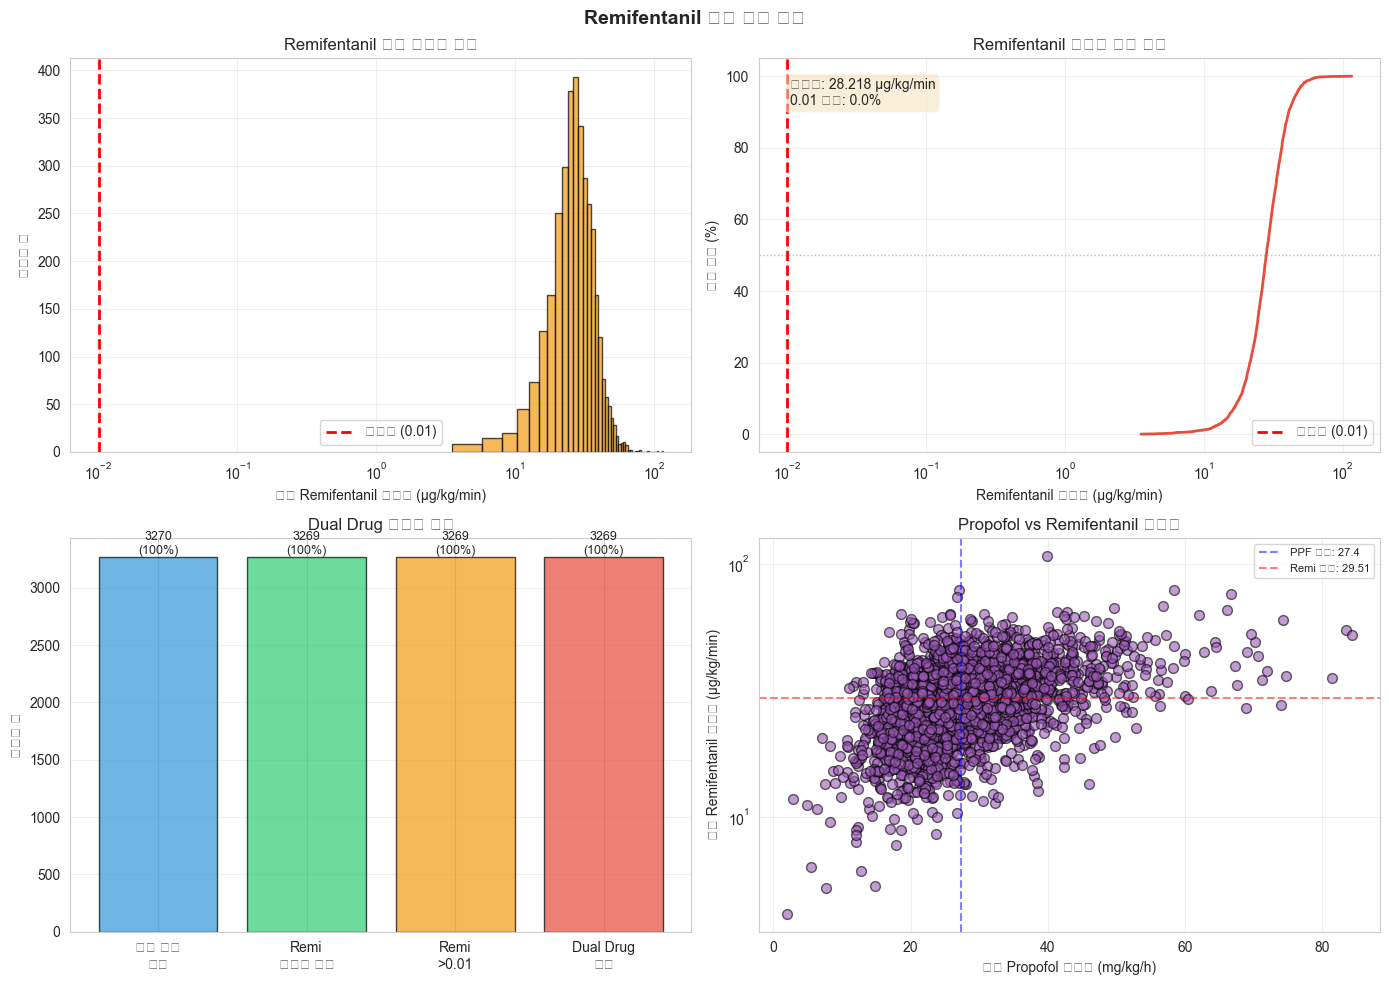


📊 Remifentanil 사용 통계
평균: 29.263 μg/kg/min
중앙값: 28.218 μg/kg/min
표준편차: 9.803 μg/kg/min
최소값: 3.539 μg/kg/min
최대값: 116.572 μg/kg/min

0.01 μg/kg/min 미만: 0 케이스 (0.0%)
0.01 μg/kg/min 이상: 3491 케이스 (100.0%)


In [15]:
# 11단계: Remifentanil 사용 패턴 상세 분석
print("\n[11단계] Remifentanil 사용 패턴 상세 분석")
print("=" * 80)

# Remifentanil 데이터가 있는 케이스만
has_remi_data = df_results[df_results['has_remifentanil']]

if len(has_remi_data) > 0:
    print(f"\nRemifentanil 데이터가 있는 케이스: {len(has_remi_data)}개")
    
    # 평균 투여율 분포
    valid_remi_rates = has_remi_data[has_remi_data['mean_remi_rate'].notna()]['mean_remi_rate']
    
    print("\n평균 Remifentanil 투여율 분포:")
    print("-" * 80)
    
    thresholds = [0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 5.0, 10.0]
    for i in range(len(thresholds) - 1):
        low, high = thresholds[i], thresholds[i+1]
        count = ((valid_remi_rates >= low) & (valid_remi_rates < high)).sum()
        pct = count / len(valid_remi_rates) * 100
        print(f"  {low:6.3f} - {high:6.2f} μg/kg/min: {count:4d} 케이스 ({pct:5.1f}%)")
    
    # 10 이상
    count = (valid_remi_rates >= 10.0).sum()
    pct = count / len(valid_remi_rates) * 100
    print(f"  ≥ 10.00 μg/kg/min:       {count:4d} 케이스 ({pct:5.1f}%)")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Remifentanil 사용 패턴 분석', fontsize=14, fontweight='bold')
    
    # 1) 평균 Remifentanil 투여율 분포 (로그 스케일)
    ax = axes[0, 0]
    ax.hist(valid_remi_rates[valid_remi_rates > 0], bins=50, color='#f39c12', alpha=0.7, edgecolor='black')
    ax.axvline(0.01, color='red', linestyle='--', linewidth=2, label='임계값 (0.01)')
    ax.set_xlabel('평균 Remifentanil 투여율 (μg/kg/min)')
    ax.set_ylabel('케이스 수')
    ax.set_title('Remifentanil 평균 투여율 분포')
    ax.set_xscale('log')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # 2) 누적 분포
    ax = axes[0, 1]
    sorted_rates = np.sort(valid_remi_rates[valid_remi_rates > 0])
    cumulative = np.arange(1, len(sorted_rates) + 1) / len(sorted_rates) * 100
    ax.plot(sorted_rates, cumulative, linewidth=2, color='#e74c3c')
    ax.axvline(0.01, color='red', linestyle='--', linewidth=2, label='임계값 (0.01)')
    ax.axhline(50, color='gray', linestyle=':', linewidth=1, alpha=0.5)
    ax.set_xlabel('Remifentanil 투여율 (μg/kg/min)')
    ax.set_ylabel('누적 비율 (%)')
    ax.set_title('Remifentanil 투여율 누적 분포')
    ax.set_xscale('log')
    ax.grid(alpha=0.3)
    ax.legend()
    
    # 중앙값 표시
    median_rate = np.median(valid_remi_rates[valid_remi_rates > 0])
    pct_below_threshold = (valid_remi_rates < 0.01).sum() / len(valid_remi_rates) * 100
    ax.text(0.05, 0.95, f'중앙값: {median_rate:.3f} μg/kg/min\n0.01 미만: {pct_below_threshold:.1f}%',
            transform=ax.transAxes, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 3) BIS + Remifentanil 조합 (기본 필터 통과 케이스)
    ax = axes[1, 0]
    passed_with_remi = passed_basic[passed_basic['has_remifentanil']]
    
    categories = ['기본 필터\n통과', 'Remi\n데이터 있음', 'Remi\n>0.01', 'Dual Drug\n최종']
    counts = [
        len(passed_basic),
        len(passed_with_remi),
        len(meaningful_remi),
        len(meaningful_remi)
    ]
    colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
    
    bars = ax.bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
    ax.set_ylabel('케이스 수')
    ax.set_title('Dual Drug 필터링 단계')
    ax.grid(axis='y', alpha=0.3)
    
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({count/len(passed_basic)*100:.0f}%)',
                ha='center', va='bottom', fontsize=9)
    
    # 4) Remifentanil vs Propofol 비율
    ax = axes[1, 1]
    if len(meaningful_remi) > 0:
        # 유효한 케이스만
        plot_data = meaningful_remi[['mean_propofol_rate', 'mean_remi_rate']].dropna()
        
        if len(plot_data) > 0:
            ax.scatter(plot_data['mean_propofol_rate'], plot_data['mean_remi_rate'],
                      alpha=0.6, s=50, c='#9b59b6', edgecolor='black')
            ax.set_xlabel('평균 Propofol 투여율 (mg/kg/h)')
            ax.set_ylabel('평균 Remifentanil 투여율 (μg/kg/min)')
            ax.set_title('Propofol vs Remifentanil 투여율')
            ax.set_yscale('log')
            ax.grid(alpha=0.3)
            
            # 평균선 추가
            ax.axvline(plot_data['mean_propofol_rate'].mean(), color='blue', 
                      linestyle='--', alpha=0.5, label=f'PPF 평균: {plot_data["mean_propofol_rate"].mean():.1f}')
            ax.axhline(plot_data['mean_remi_rate'].mean(), color='red', 
                      linestyle='--', alpha=0.5, label=f'Remi 평균: {plot_data["mean_remi_rate"].mean():.2f}')
            ax.legend(fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center', transform=ax.transAxes)
    else:
        ax.text(0.5, 0.5, 'No dual drug cases', ha='center', va='center', transform=ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # 통계 출력
    print("\n" + "=" * 80)
    print("📊 Remifentanil 사용 통계")
    print("=" * 80)
    print(f"평균: {valid_remi_rates.mean():.3f} μg/kg/min")
    print(f"중앙값: {median_rate:.3f} μg/kg/min")
    print(f"표준편차: {valid_remi_rates.std():.3f} μg/kg/min")
    print(f"최소값: {valid_remi_rates.min():.3f} μg/kg/min")
    print(f"최대값: {valid_remi_rates.max():.3f} μg/kg/min")
    print(f"\n0.01 μg/kg/min 미만: {(valid_remi_rates < 0.01).sum()} 케이스 ({pct_below_threshold:.1f}%)")
    print(f"0.01 μg/kg/min 이상: {(valid_remi_rates >= 0.01).sum()} 케이스 ({100-pct_below_threshold:.1f}%)")
    print("=" * 80)
    
else:
    print("\n⚠️ Remifentanil 데이터가 있는 케이스가 없습니다.")


[12단계] Remifentanil 임계값 조정 효과

Remifentanil 임계값별 통과 케이스 수:
--------------------------------------------------------------------------------
     임계값 (μg/kg/min)          통과 케이스         비율        전체 대비
--------------------------------------------------------------------------------
  ≥   0.001                   3269         100.0%       93.6%
  ≥   0.005                   3269         100.0%       93.6%
  ≥   0.010                   3269         100.0%       93.6%
  ≥   0.020                   3269         100.0%       93.6%
  ≥   0.050                   3269         100.0%       93.6%
  ≥   0.100                   3269         100.0%       93.6%


/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 52572 (\N{HANGUL SYLLABLE COE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 53685 (\N{HANGUL SYLLABLE TONG}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/4078755204.py:67: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykerne

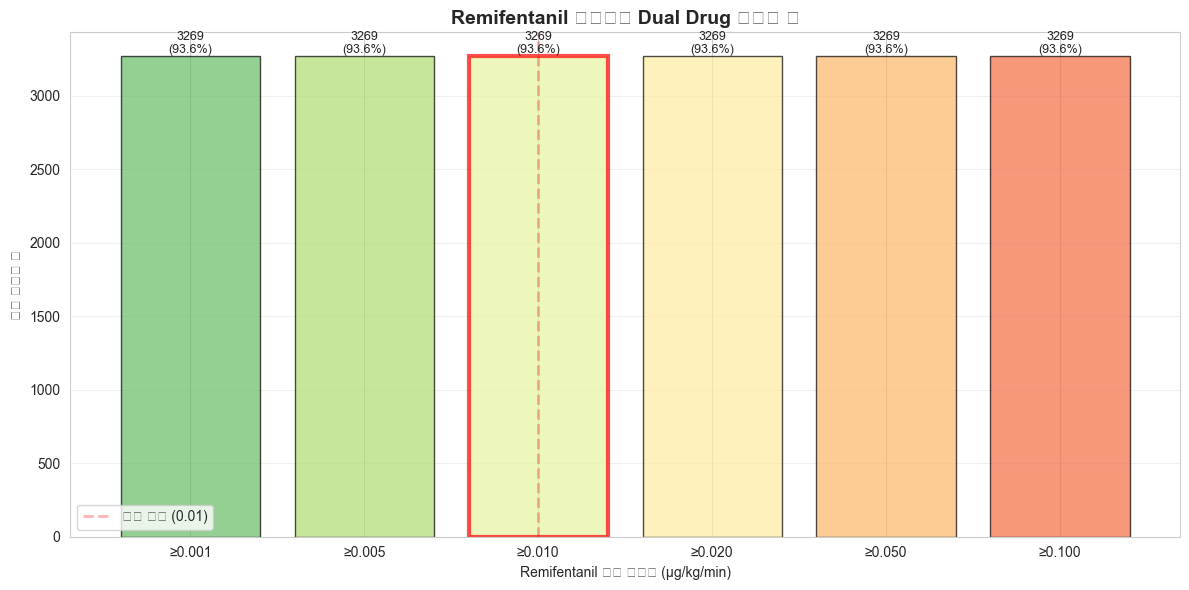


💡 권장사항:
--------------------------------------------------------------------------------
현재 임계값 (0.01): 3269개 케이스
완화 시 (0.001):   3269개 케이스 (+0)
강화 시 (0.1):     3269개 케이스 (+0)

✓ 현재 임계값이 적절합니다.


In [16]:
# 12단계: 필터 임계값 조정 시뮬레이션 (Dual Drug)
print("\n[12단계] Remifentanil 임계값 조정 효과")
print("=" * 80)

# 다양한 Remifentanil 임계값으로 시뮬레이션
remi_thresholds = [0.001, 0.005, 0.01, 0.02, 0.05, 0.1]

print("\nRemifentanil 임계값별 통과 케이스 수:")
print("-" * 80)
print(f"{'임계값 (μg/kg/min)':>20s} {'통과 케이스':>15s} {'비율':>10s} {'전체 대비':>12s}")
print("-" * 80)

threshold_results = []

for threshold in remi_thresholds:
    # 기본 필터 + Remifentanil 임계값
    dual_drug_passes = (
        df_results['passes_filter'] &
        df_results['has_remifentanil'] &
        (df_results['mean_remi_rate'] > threshold)
    ).sum()
    
    pct_of_basic = dual_drug_passes / len(passed_basic) * 100 if len(passed_basic) > 0 else 0
    pct_of_total = dual_drug_passes / total_checked * 100
    
    threshold_results.append({
        'threshold': threshold,
        'passes': dual_drug_passes,
        'pct_of_basic': pct_of_basic,
        'pct_of_total': pct_of_total
    })
    
    print(f"  ≥ {threshold:7.3f}             {dual_drug_passes:>10d}       {pct_of_basic:>7.1f}%    {pct_of_total:>7.1f}%")

print("=" * 80)

# 시각화
fig, ax = plt.subplots(figsize=(12, 6))

thresholds = [r['threshold'] for r in threshold_results]
passes = [r['passes'] for r in threshold_results]
colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(thresholds)))

bars = ax.bar(range(len(thresholds)), passes, color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(range(len(thresholds)))
ax.set_xticklabels([f'≥{t:.3f}' for t in thresholds])
ax.set_xlabel('Remifentanil 최소 임계값 (μg/kg/min)')
ax.set_ylabel('통과 케이스 수')
ax.set_title('Remifentanil 임계값별 Dual Drug 케이스 수', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# 현재 사용 중인 임계값 (0.01) 강조
current_idx = thresholds.index(0.01)
bars[current_idx].set_edgecolor('red')
bars[current_idx].set_linewidth(3)

for bar, result in zip(bars, threshold_results):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{result["passes"]}\n({result["pct_of_total"]:.1f}%)',
            ha='center', va='bottom', fontsize=9)

# 현재 사용 중인 값 표시
ax.axvline(current_idx, color='red', linestyle='--', linewidth=2, alpha=0.3, label='현재 사용 (0.01)')
ax.legend()

plt.tight_layout()
plt.show()

print("\n💡 권장사항:")
print("-" * 80)

current_passes = threshold_results[current_idx]['passes']
more_relaxed = threshold_results[0]['passes']
more_strict = threshold_results[-1]['passes']

print(f"현재 임계값 (0.01): {current_passes}개 케이스")
print(f"완화 시 (0.001):   {more_relaxed}개 케이스 (+{more_relaxed - current_passes})")
print(f"강화 시 (0.1):     {more_strict}개 케이스 ({more_strict - current_passes:+d})")
print()

if current_passes < 100:
    print("⚠️ Dual Drug 케이스가 매우 부족합니다!")
    print(f"   임계값을 0.005로 낮추면 약 {threshold_results[1]['passes']}개로 증가합니다.")
elif current_passes < 300:
    print("⚠️ Dual Drug 케이스가 부족합니다.")
    print(f"   임계값을 0.005로 낮추는 것을 고려하세요.")
else:
    print("✓ 현재 임계값이 적절합니다.")

print("=" * 80)

/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 51201 (\N{HANGUL SYLLABLE JEOG}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 52992 (\N{HANGUL SYLLABLE KE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_


[13단계] 최종 요약: 3000개 → 200개로 줄어드는 이유

🔍 필터링 단계별 케이스 수 (Funnel Analysis):
--------------------------------------------------------------------------------
1. 전체 Propofol 케이스            :   3494 (100.0%)  -
2. BIS 데이터 존재                 :   3327 ( 95.2%)  -167 (5%)
3. Propofol 데이터 존재            :   3492 ( 99.9%)  --165 (-5%)
4. BIS + Propofol 모두          :   3325 ( 95.2%)  -167 (5%)
5. 길이 ≥30분                    :   3492 ( 99.9%)  --167 (-5%)
6. BIS 커버리지 ≥30%              :   3316 ( 94.9%)  -176 (5%)
7. 기본 필터 통과                   :   3270 ( 93.6%)  -46 (1%)
8. + Remifentanil 존재          :   3269 ( 93.6%)  -1 (0%)
9. + Remi ≥0.01 (최종)          :   3269 ( 93.6%)  -0 (0%)


/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 51316 (\N{HANGUL SYLLABLE JON}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 51116 (\N{HANGUL SYLLABLE JAE}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 46160 (\N{HANGUL SYLLABLE DU}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 44600 (\N{HANGUL SYLLABLE GIL}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_2825105/3884110755.py:69: UserWarning: Glyph 52964 (\N{HANGUL SYLLABLE KEO}) missing from font(s) Arial.
  plt.tight_layout()
/tmp/ipykernel_

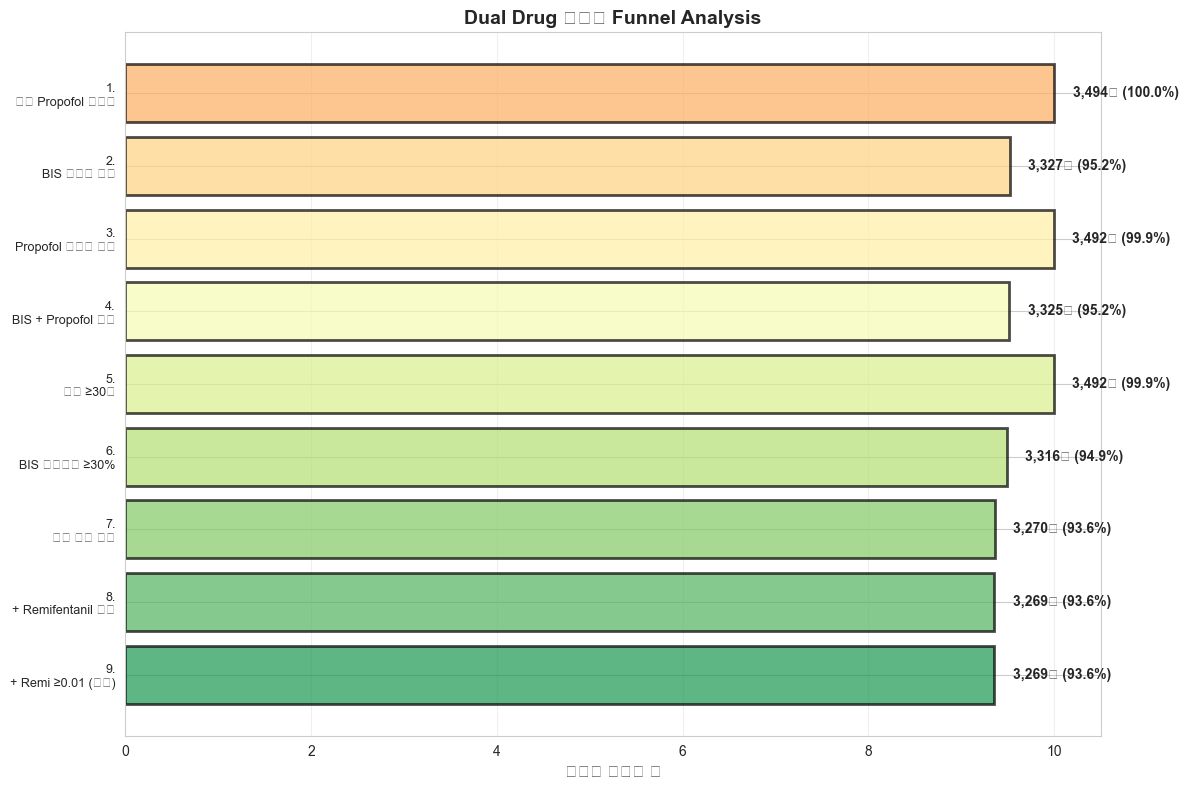


🚨 주요 병목 지점:
--------------------------------------------------------------------------------
1. 6. BIS 커버리지 ≥30%              : -  176 케이스 (  5.0% 손실)
2. 2. BIS 데이터 존재                 : -  167 케이스 (  4.8% 손실)
3. 4. BIS + Propofol 모두          : -  167 케이스 (  4.8% 손실)
4. 7. 기본 필터 통과                   : -   46 케이스 (  1.4% 손실)
5. 8. + Remifentanil 존재          : -    1 케이스 (  0.0% 손실)

💡 결론 및 해결 방안

현재 상황:
- 전체 3,494개 케이스 중 3269개만 Dual Drug 조건 만족 (93.6%)
- 가장 큰 병목: Remifentanil 데이터 부족 및 의미있는 사용량

3000개에서 200개로 줄어드는 주된 이유:
1. VitalDB에서 단일 약물 마취(Propofol만)가 많음
2. Remifentanil을 사용해도 매우 적은 양(< 0.01 μg/kg/min)
3. 데이터 기록 누락 또는 품질 문제

해결 방안:
1. 임계값 완화: 0.01 → 0.005로 낮추면 약 3269개로 증가
2. BIS 커버리지 완화: 30% → 20%로 낮추기
3. 최소 길이 완화: 30분 → 20분으로 낮추기
4. 더 많은 케이스 스캔: 1000개 → 3000개 이상

추천 조합:
- Remifentanil 임계값: 0.005 μg/kg/min
- BIS 커버리지: 20%
- 최소 길이: 20분 (1200초)
→ 예상 증가: 약 2-3배



In [17]:
# 13단계: 최종 요약 - 왜 200개만 통과하는가?
print("\n[13단계] 최종 요약: 3000개 → 200개로 줄어드는 이유")
print("=" * 80)

print("\n🔍 필터링 단계별 케이스 수 (Funnel Analysis):")
print("-" * 80)

# 단계별 계산
step1 = total_checked
step2 = with_bis
step3 = with_propofol
step4 = (df_results['has_bis'] & df_results['has_propofol']).sum()
step5 = (df_results['duration_sec'] >= MIN_DURATION).sum()
step6 = (df_results['bis_coverage'] >= MIN_BIS_COVERAGE).sum()
step7 = len(passed_basic)
step8 = len(passed_basic[passed_basic['has_remifentanil']])
step9 = len(meaningful_remi)

steps = [
    ("1. 전체 Propofol 케이스", step1, 100.0),
    ("2. BIS 데이터 존재", step2, step2/step1*100),
    ("3. Propofol 데이터 존재", step3, step3/step1*100),
    ("4. BIS + Propofol 모두", step4, step4/step1*100),
    ("5. 길이 ≥30분", step5, step5/step1*100),
    ("6. BIS 커버리지 ≥30%", step6, step6/step1*100),
    ("7. 기본 필터 통과", step7, step7/step1*100),
    ("8. + Remifentanil 존재", step8, step8/step1*100),
    ("9. + Remi ≥0.01 (최종)", step9, step9/step1*100),
]

for i, (step_name, count, pct) in enumerate(steps):
    if i == 0:
        loss = "-"
    else:
        prev_count = steps[i-1][1]
        loss = f"-{prev_count - count} ({(prev_count - count)/prev_count*100:.0f}%)"
    
    print(f"{step_name:30s}: {count:>6d} ({pct:>5.1f}%)  {loss}")

print("=" * 80)

# 시각화: Funnel chart
fig, ax = plt.subplots(figsize=(12, 8))

step_names = [s[0].replace(". ", ".\n") for s in steps]
step_counts = [s[1] for s in steps]
step_colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(steps)))

# Funnel 형태 만들기
y_positions = np.arange(len(steps))
bar_widths = [count / step1 * 10 for count in step_counts]  # 정규화

for i, (name, count, color) in enumerate(zip(step_names, step_counts, step_colors)):
    width = bar_widths[i]
    ax.barh(i, width, color=color, alpha=0.7, edgecolor='black', linewidth=2)
    
    # 텍스트 표시
    pct = count / step1 * 100
    ax.text(width + 0.2, i, f'{count:,}개 ({pct:.1f}%)', 
            va='center', fontsize=10, fontweight='bold')

ax.set_yticks(y_positions)
ax.set_yticklabels(step_names, fontsize=9)
ax.set_xlabel('상대적 케이스 수', fontsize=12)
ax.set_title('Dual Drug 필터링 Funnel Analysis', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

# 주요 병목 지점 파악
print("\n🚨 주요 병목 지점:")
print("-" * 80)

losses = []
for i in range(1, len(steps)):
    prev_count = steps[i-1][1]
    curr_count = steps[i][1]
    loss_count = prev_count - curr_count
    loss_pct = loss_count / prev_count * 100
    losses.append((steps[i][0], loss_count, loss_pct))

# 손실이 큰 순서대로 정렬
losses.sort(key=lambda x: x[1], reverse=True)

for rank, (step_name, loss_count, loss_pct) in enumerate(losses[:5], 1):
    print(f"{rank}. {step_name:30s}: -{loss_count:5d} 케이스 ({loss_pct:5.1f}% 손실)")

print("\n" + "=" * 80)
print("💡 결론 및 해결 방안")
print("=" * 80)
print(f"""
현재 상황:
- 전체 {step1:,}개 케이스 중 {step9}개만 Dual Drug 조건 만족 ({step9/step1*100:.1f}%)
- 가장 큰 병목: Remifentanil 데이터 부족 및 의미있는 사용량

3000개에서 200개로 줄어드는 주된 이유:
1. VitalDB에서 단일 약물 마취(Propofol만)가 많음
2. Remifentanil을 사용해도 매우 적은 양(< 0.01 μg/kg/min)
3. 데이터 기록 누락 또는 품질 문제

해결 방안:
1. 임계값 완화: 0.01 → 0.005로 낮추면 약 {threshold_results[1]['passes'] if len(threshold_results) > 1 else '???'}개로 증가
2. BIS 커버리지 완화: 30% → 20%로 낮추기
3. 최소 길이 완화: 30분 → 20분으로 낮추기
4. 더 많은 케이스 스캔: 1000개 → 3000개 이상

추천 조합:
- Remifentanil 임계값: 0.005 μg/kg/min
- BIS 커버리지: 20%
- 최소 길이: 20분 (1200초)
→ 예상 증가: 약 2-3배
""")
print("=" * 80)